In [14]:
import pandas as pd
from imblearn.over_sampling import SMOTENC
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, f1_score, roc_auc_score

df = pd.read_csv('/SouthGermanCredit.asc', sep=' ')



target_col = 'credit_risk'
X = df.drop(target_col, axis=1)
y = df[target_col]



numeric_features = ['duration', 'amount', 'age']


categorical_features_indices = [
    i for i, col in enumerate(X.columns) if col not in numeric_features
]

print(f"kategorik sütun sayısı: {len(categorical_features_indices)}")
print(f"Sayısal sütunlar: {numeric_features}")





X_temp, X_test, y_temp, y_test = train_test_split(
    X, y,
    test_size=0.20,
    stratify=y,
    random_state=42
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp,
    test_size=0.25,
    stratify=y_temp,
    random_state=42
)

print(f"\nBEFORE SMOTE test: {Counter(y_test)}")
print(f"\nBEFORE SMOTE train: {Counter(y_train)}")
print(f"\nBEFORE SMOTE val: {Counter(y_val)}")

smote_nc = SMOTENC(
    categorical_features=categorical_features_indices,
    random_state=42,
    sampling_strategy='auto'
)

X_train_resampled, y_train_resampled = smote_nc.fit_resample(X_train, y_train)





categorical_cols = [c for c in X_train_resampled.columns if c not in ['duration', 'amount', 'age']]


preprocessor = ColumnTransformer(
    transformers=[('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), categorical_cols)],
    remainder='passthrough',
    verbose_feature_names_out=False
).set_output(transform="pandas")


X_train_encoded = preprocessor.fit_transform(X_train_resampled)
X_val_encoded   = preprocessor.transform(X_val)
X_test_encoded  = preprocessor.transform(X_test)


print(f"AFTER SMOTE : {Counter(y_train_resampled)}")

"""print("\nÜretilen veriden örnekler:")
print(X_train_encoded)"""


dummy = DummyClassifier(strategy='most_frequent')
dummy.fit(X_train, y_train)
print(f"Baseline Score: {dummy.score(X_test_encoded, y_test):.4f}")

print("\nRandom Forest Sonuçları")
rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    min_samples_leaf=4,
    n_jobs=-1
)
#encoded performance
rf_model.fit(X_train_encoded, y_train_resampled)


y_pred_rf_val = rf_model.predict(X_val_encoded)
score_rf_val=f1_score(y_val, y_pred_rf_val)

print(classification_report(y_val, y_pred_rf_val))
print("f1_val:", score_rf_val)

y_pred_rf = rf_model.predict(X_test_encoded)
score_rf=f1_score(y_test, y_pred_rf)

print(classification_report(y_test, y_pred_rf))
print("f1:", score_rf)

#not encoded performance
rf_model.fit(X_train_resampled, y_train_resampled)


y_pred_rf_val = rf_model.predict(X_val)
score_rf_val=f1_score(y_val, y_pred_rf_val)

print(classification_report(y_val, y_pred_rf_val))
print("f1_val:", score_rf_val)

y_pred_rf = rf_model.predict(X_test)
score_rf=f1_score(y_test, y_pred_rf)

print(classification_report(y_test, y_pred_rf))
print("f1:", score_rf)



print("\nXGBoost Sonuçları")
xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    eval_metric='logloss',
    random_state=42,
)
#encoded performance
xgb_model.fit(X_train_encoded, y_train_resampled)

y_pred_xgb_val = xgb_model.predict(X_val_encoded)
score_xgb_val=f1_score(y_val, y_pred_xgb_val)

print(classification_report(y_val, y_pred_xgb_val))
print("f1:_val", score_xgb_val)

y_pred_xgb = xgb_model.predict(X_test_encoded)
score_xgb=f1_score(y_test, y_pred_xgb)

print(classification_report(y_test, y_pred_xgb))
print("f1:", score_xgb)

#normal performance
xgb_model.fit(X_train_resampled, y_train_resampled)

y_pred_xgb_val = xgb_model.predict(X_val)
score_xgb_val=f1_score(y_val, y_pred_xgb_val)

print(classification_report(y_val, y_pred_xgb_val))
print("f1:_val", score_xgb_val)

y_pred_xgb = xgb_model.predict(X_test)
score_xgb=f1_score(y_test, y_pred_xgb)

print(classification_report(y_test, y_pred_xgb))
print("f1:", score_xgb)

"""
#brute force parameter search (best f1 with 0.8303249097472925 {'max_depth': 8, 'min_samples_leaf': 2, 'n_estimators': 54})
maks_score_tree=0
maks_score_depth=0
maks_score_leaf=0
maks_score=0
for tree in range(50,350):
    for depth in range(5,30):
        for leaf in range(1,6):
            rf_model_hp = RandomForestClassifier(
                n_estimators=tree,
                max_depth=depth,
                min_samples_leaf=leaf,
                random_state=42,
                n_jobs=-1)
            rf_model_hp.fit(X_train_resampled, y_train_resampled)
            y_pred_rf = rf_model_hp.predict(X_val)
            print(y_pred_rf)
            score=f1_score(y_val, y_pred_rf)
            if score>maks_score:
                maks_score_tree=tree
                maks_score_depth=depth
                maks_score_leaf=leaf
                maks_score=score
    print(maks_score,maks_score_tree,maks_score_depth,maks_score_leaf)
"""
"""
#Grid search parameter search (f1 score is worse than brute froce with Best F1: 0.81884 at validation Params: {'max_depth': 9, 'min_samples_leaf': 3, 'n_estimators': 62})
print("\nRandom Forest grid search Sonuçları")
param_grid = {'n_estimators': range(50,100),
              'max_depth': range(5,10),
              'min_samples_leaf': range(1,4)}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42), param_grid, cv=3, scoring='f1', n_jobs=-1)
grid_search.fit(X_train_resampled, y_train_resampled)
print(f"Best F1: {grid_search.best_score_:.4f} Params: {grid_search.best_params_}")
best_rf_model = grid_search.best_estimator_

y_pred_rf_best = best_rf_model.predict(X_val)

score_rf_best_val=f1_score(y_val, y_pred_rf_best)
print(classification_report(y_val, y_pred_rf_best))
print("f1_val:", score_rf_best_val)

y_pred_rf_best = best_rf_model.predict(X_test)

score_rf_best=f1_score(y_test, y_pred_rf_best)
print(classification_report(y_test, y_pred_rf_best))
print("f1:", score_rf_best)
"""

print("\nRandom Forest HyperParamater Sonuçları")
rf_model_hp = RandomForestClassifier(
                n_estimators=54,
                max_depth=8,
                min_samples_leaf=2,
                random_state=42,
                n_jobs=-1)
rf_model_hp.fit(X_train_resampled, y_train_resampled)

y_pred_rf_hp_val = rf_model_hp.predict(X_val)

score_rf_hp_val=f1_score(y_val, y_pred_rf_hp_val)
print(classification_report(y_val, y_pred_rf_hp_val))
print("f1_val:", score_rf_hp_val)

y_pred_rf_hp = rf_model_hp.predict(X_test)

score_rf_hp=f1_score(y_test, y_pred_rf_hp)
print(classification_report(y_test, y_pred_rf_hp))
print("f1:", score_rf_hp)




kategorik sütun sayısı: 17
Sayısal sütunlar: ['duration', 'amount', 'age']

BEFORE SMOTE test: Counter({1: 140, 0: 60})

BEFORE SMOTE train: Counter({1: 420, 0: 180})

BEFORE SMOTE val: Counter({1: 140, 0: 60})
AFTER SMOTE : Counter({1: 420, 0: 420})
Baseline Score: 0.7000

Random Forest Sonuçları
              precision    recall  f1-score   support

           0       0.60      0.62      0.61        60
           1       0.83      0.82      0.83       140

    accuracy                           0.76       200
   macro avg       0.72      0.72      0.72       200
weighted avg       0.76      0.76      0.76       200

f1_val: 0.8273381294964028
              precision    recall  f1-score   support

           0       0.58      0.63      0.60        60
           1       0.84      0.80      0.82       140

    accuracy                           0.75       200
   macro avg       0.71      0.72      0.71       200
weighted avg       0.76      0.75      0.75       200

f1: 0.81751824817518

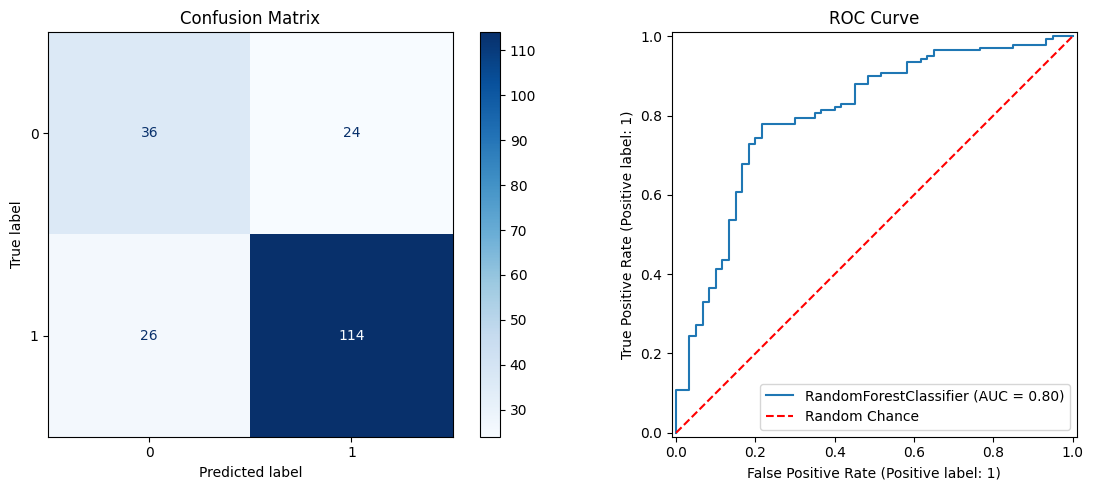

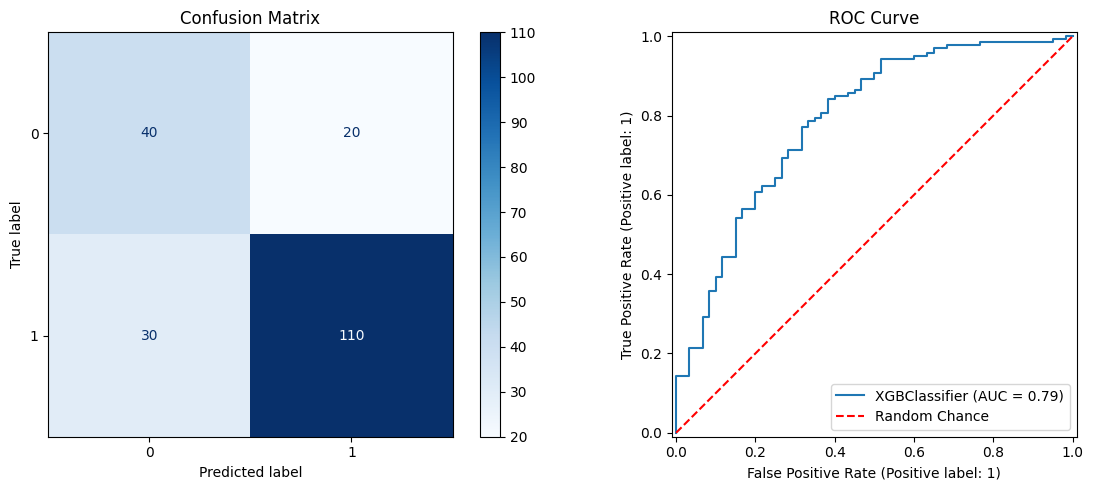

In [15]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay, PrecisionRecallDisplay

#First model graph
model = rf_model_hp


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))



ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    cmap='Blues',
    normalize=None,
    ax=ax1
)
ax1.set_title("Confusion Matrix")



RocCurveDisplay.from_estimator(
    model,
    X_test,
    y_test,
    ax=ax2
)
ax2.set_title("ROC Curve")

ax2.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Chance')
ax2.legend()

plt.tight_layout()
plt.show()


fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

#Second model graph
model = xgb_model

ConfusionMatrixDisplay.from_estimator(
    model,
    X_test,
    y_test,
    cmap='Blues',
    normalize=None,
    ax=ax1
)
ax1.set_title("Confusion Matrix")


RocCurveDisplay.from_estimator(
    model,
    X_test,
    y_test,
    ax=ax2
)
ax2.set_title("ROC Curve")

ax2.plot([0, 1], [0, 1], linestyle='--', color='red', label='Random Chance')
ax2.legend()

plt.tight_layout()
plt.show()


In [20]:
import seaborn as sns



results_df = X_test.copy()
results_df['Actual'] = y_test
results_df['Predicted'] = y_pred_rf


errors_df = results_df[results_df['Actual'] != results_df['Predicted']]


print(f"Error count: {len(errors_df)}")


results_df['Status'] = results_df.apply(lambda x: 'False' if x['Actual'] != x['Predicted'] else 'True', axis=1)


error_rates = results_df.groupby('purpose')['Status'].value_counts(normalize=True).unstack()
print(error_rates)

Error count: 48
Status      False      True
purpose                    
0        0.229167  0.770833
1        0.153846  0.846154
2        0.230769  0.769231
3        0.193548  0.806452
4             NaN  1.000000
5        0.666667  0.333333
6        0.100000  0.900000
9        0.428571  0.571429
10       0.666667  0.333333


/tmp/ipython-input-1418563258.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(data=scores_df, x='Model', y='F1 Score', palette='magma')


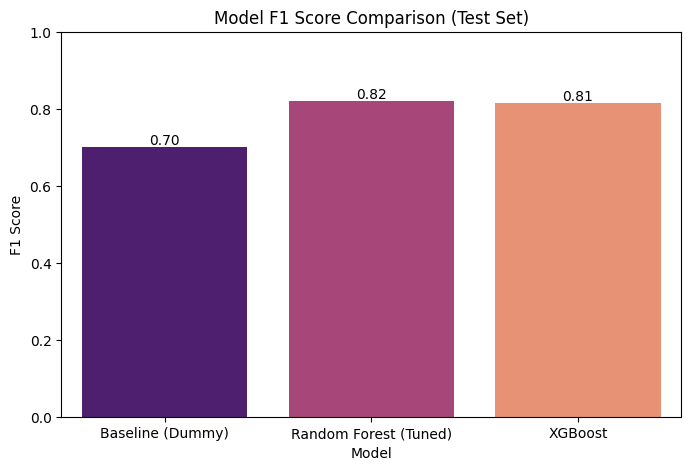

In [17]:
model_scores = {
    'Baseline (Dummy)': 0.70,
    'Random Forest (Tuned)': score_rf_hp,
    'XGBoost': score_xgb,
}

scores_df = pd.DataFrame(list(model_scores.items()), columns=['Model', 'F1 Score'])


plt.figure(figsize=(8, 5))
ax = sns.barplot(data=scores_df, x='Model', y='F1 Score', palette='magma')


for i in ax.containers:
    ax.bar_label(i, fmt='%.2f')

plt.title('Model F1 Score Comparison (Test Set)')
plt.ylim(0, 1.0)
plt.ylabel('F1 Score')
plt.show()

/tmp/ipython-input-4227089151.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette='viridis')


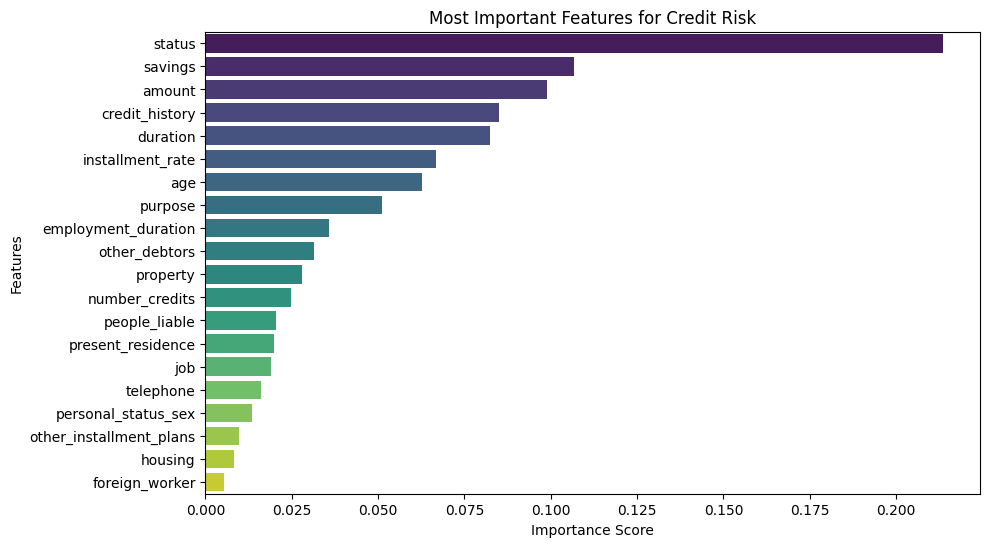

In [19]:

feature_names = X_train.columns
importances = rf_model.feature_importances_


feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
feat_imp_df = feat_imp_df.sort_values(by='Importance', ascending=False)


plt.figure(figsize=(10, 6))
sns.barplot(data=feat_imp_df, x='Importance', y='Feature', palette='viridis')
plt.title('Most Important Features for Credit Risk')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()